# Ten-Bar Truss Weight Minimization
Created by Yi-Ping Chen, last modified in Jan. 2025 for ME341.

In [47]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random
import math

### Define functions

In [48]:
# Finite Element Analysis code
def FEA(r):
    length = 9.14  # unit: m
    E = 200e9
    F = np.zeros(12)  # unit: N
    F[3] = -1e7
    F[7] = -1e7

    # Node Table
    n = np.array([
        [2, 1], [2, 0], [1, 1], [1, 0], [0, 1], [0, 0]
    ]) * length

    # Element Connectivity Table
    ec = np.array([
        [3, 5], [1, 3], [4, 6], [2, 4], [3, 4], 
        [1, 2], [4, 5], [3, 6], [2, 3], [1, 4]
    ]) - 1  # Convert to zero-based indexing

    # Initialize element properties
    num_elements = 10
    length_e = np.zeros(num_elements)
    l = np.zeros(num_elements)
    m = np.zeros(num_elements)

    # Compute element lengths and direction cosines
    for i in range(num_elements):
        diff = n[ec[i, 1]] - n[ec[i, 0]]
        length_e[i] = np.linalg.norm(diff)
        l[i] = diff[0] / length_e[i]
        m[i] = diff[1] / length_e[i]

    # Element radius and area
    r = np.concatenate([np.full(6, r[0]), np.full(4, r[1])])
    A = np.pi * r**2

    # Global stiffness matrix
    K = np.zeros((12, 12))
    for i in range(num_elements):
        k_small = (E * A[i] / length_e[i]) * np.array([
            [l[i]**2, l[i]*m[i]], 
            [l[i]*m[i], m[i]**2]
        ])
        k = np.zeros((12, 12))
        idx = np.array([
            ec[i, 0] * 2, ec[i, 0] * 2 + 1, 
            ec[i, 1] * 2, ec[i, 1] * 2 + 1
        ])
        k[np.ix_(idx[:2], idx[:2])] += k_small
        k[np.ix_(idx[2:], idx[2:])] += k_small
        k[np.ix_(idx[:2], idx[2:])] -= k_small
        k[np.ix_(idx[2:], idx[:2])] -= k_small
        K += k

    # DOF Reduction
    K_re = K[:8, :8]
    F_re = F[:8]

    # Displacement Calculation
    Q_re = np.linalg.solve(K_re, F_re)
    Q = np.concatenate([Q_re, np.zeros(4)])

    # Stress Calculation
    stress = np.zeros(num_elements)
    for i in range(num_elements):
        idx = np.array([
            ec[i, 0] * 2, ec[i, 0] * 2 + 1, 
            ec[i, 1] * 2, ec[i, 1] * 2 + 1
        ])
        stress[i] = (E / length_e[i]) * np.dot(
            np.array([-l[i], -m[i], l[i], m[i]]), Q[idx]
        )

    # Reaction Force Calculation
    K_R = K[8:, :]
    R = np.dot(K_R, Q)
    R = np.concatenate([np.zeros(8), R])

    return length_e, stress, r, Q


def nonlincon(r):
    """
    constraints (these are normalized to be > 0 if constraint is violated)
    you can find the unchanged constraints on the original ten_bar_python file
    """
    length_e, stress, r_e, Q = FEA(r)

    # Material and geometry
    E = 200e9           # Young's modulus
    Y = 250e6           # yield stress
    I = (np.pi/4)*r_e**4
    dis_max = 0.02      # maximum displacement

    num_elems = len(stress)  # should be 10
    g_buckling = np.zeros(num_elems)
    g_stress   = np.zeros(num_elems)

    # Internal axial force in element i
    #   F_internal[i] = A_i * sigma_i = (pi * r_e[i]^2) * stress[i]
    #   (Sign convention: negative => compression)
    F_internal = np.pi*(r_e**2)*stress

    for i in range(num_elems):
        # Buckling constraint:
        #   If F < 0 (compression), we want |F| <= pi^2 E I / L^2 
        #   i.e. -F_internal(i) <= pi^2 E I / L^2
        #   or  (-F_internal(i) - pi^2 E I / L^2) <= 0
        # We typically set g_buckling[i] = -F_comp - (pi^2 E I / L^2).
        # But we only apply it if the element is in compression:

        if F_internal[i] < 0:  # compression
            F_comp = -F_internal[i]
            # We want F_comp - pi^2 E I / L^2 <= 0
            g_buckling[i] = F_comp - (np.pi**2 * E * I[i])/(length_e[i]**2)
        else:
            # If tension or zero, buckling is not active => g<=0 is trivially satisfied
            g_buckling[i] = -1e-6  # or 0, something safely negative.

        # Stress constraint:
        #   |sigma| - Y <= 0
        g_stress[i] = abs(stress[i]) - Y

    # Displacement constraint at node #2:
    #   sqrt(Q[2]^2 + Q[3]^2) - dis_max <= 0
    # or equivalently Q[2]^2 + Q[3]^2 - dis_max^2 <= 0
    disp_constraint = (Q[2]**2 + Q[3]**2) - (dis_max**2)

    # Collect all constraints
    g = np.concatenate([g_buckling, g_stress, [disp_constraint]])
    return g

# Define objective function
def obj(r):
    length = 9.14
    density = 7860
    weight = (6 * np.pi * r[0]**2 * length + 4 * np.pi * r[1]**2 * length * np.sqrt(2)) * density
    return weight


### Optimizer Setup

In [49]:
# Initial conditions and bounds
r0 = [0.2, 0.3]  # Initial guess
bounds = [(0.01, 0.5), (0.01, 0.5)]  # Bounds for r1 and r2

# Simulated Annealing to solve optimization problem

def get_neighbor(x, step_size):
    neighbor = x[:]
    index = random.randint(0, len(x) - 1)
    neighbor[index] += random.uniform(-step_size, step_size)
    return neighbor

def penalty_function(r):
    """
    Simple quadratic penalty for each violated constraint.
    If g_i > 0, constraint is violated; accumulate penalty.
    """
    g = nonlincon(r)
    # large alpha to ensure constraints are strongly enforced
    alpha = 1e16
    penalty_val = 0.0
    for val in g:
        if val > 0:
            penalty_val += val**2
    return alpha * penalty_val

def energy(r):
    """
    Energy = objective + penalty
    """
    return obj(r) + penalty_function(r)

def clamp_to_bounds(x, bounds):
    """
    Clamps each coordinate of x to the [lower, upper] range given
    in 'bounds' list of tuples.
    """
    x_clamped = []
    for val, (low, high) in zip(x, bounds):
        x_clamped.append(min(max(val, low), high))
    return x_clamped

def simulated_annealing(
    r0,
    bounds,
    T_max=1e5,       # Initial "high" temperature
    T_min=1e-2,      # Final (low) temperature
    cooling_rate=0.98,
    step_size=0.01,
    max_iter=5000
):
    """
    A simple Simulated Annealing procedure using:
      - Quadratic penalty for constraint violations
      - Exponential cooling schedule T_{k+1} = cooling_rate * T_k
    """

    # Initialize
    current = clamp_to_bounds(r0, bounds)
    current_energy = energy(current)
    history = []

    best = current[:]
    best_energy = current_energy

    T = T_max
    iteration = 0

    # Main SA loop
    while T > T_min and iteration < max_iter:
        iteration += 1
        history.append(current[:])

        # Generate neighbor
        candidate = get_neighbor(current, step_size)
        # Enforce bounds
        candidate = clamp_to_bounds(candidate, bounds)

        # Compute new energy
        candidate_energy = energy(candidate)

        # If better, accept
        if candidate_energy < current_energy:
            current = candidate
            current_energy = candidate_energy
            # Check if best
            if candidate_energy < best_energy:
                best = candidate
                best_energy = candidate_energy
        else:
            # Otherwise accept w/ Boltzmann probability
            deltaE = candidate_energy - current_energy
            accept_prob = np.exp(-deltaE / T)
            if random.random() < accept_prob:
                current = candidate
                current_energy = candidate_energy

        # Cool down
        T = T * cooling_rate

        # Optionally print progress occasionally
        if iteration % 500 == 0:
            print(f"Iter {iteration}: T={T:.4g}, best_energy={best_energy:.4g}, current_energy={current_energy:.4g}")
    return best, best_energy, history

best_solution, best_val, history = simulated_annealing(
    r0=r0,
    bounds=bounds,
    T_max=1e5,
    T_min=1e-2,
    cooling_rate=0.95,
    step_size=0.01,
    max_iter=5000
)

print("\nSimulated Annealing complete.")
print("Best solution found:", best_solution)
print("Best (obj + penalty) value:", best_val)
print("Objective alone:", obj(best_solution))
print("Constraints (should be <= 0):", nonlincon(best_solution))




Simulated Annealing complete.
Best solution found: [0.2579081948212022, 0.3704345756897388]
Best (obj + penalty) value: 265267.63645272277
Objective alone: 265267.0991472947
Constraints (should be <= 0): [-1.00000000e-06 -1.00000000e-06 -6.14797435e+07 -7.57184699e+07
 -1.00000000e-06 -1.00000000e-06 -1.00000000e-06 -1.61467248e+08
 -1.00000000e-06 -1.69614919e+08 -1.57300220e+08 -2.32724496e+08
 -1.51283075e+08 -2.19421327e+08 -2.35733069e+08 -2.32724496e+08
 -2.15132398e+08 -2.19257292e+08 -2.29037606e+08 -2.38157239e+08
  7.33011206e-09]


In [50]:
def is_feasible(r):
    """
    Returns True if 'r' is feasible, i.e., all constraints g_i(r)<=0.
    Otherwise returns False.

    GEMINI GENERATED
    """
    g = nonlincon(r)    # Calls your existing constraints function
    return np.all(g <= 0)

is_feasible(best_solution)

np.False_

## Result Validation

In [51]:
# AI GEN CODE DO NOT USE IT IS BUGGY AS
# xBest = best_solution
# def nonlincon(r):
#     ''' 
#     Nonlinear constraints
#     '''
#     length_e, stress, r_d, Q = FEA(r)  # Assuming FEA is defined elsewhere and returns these values

#     Y = 250e6  # Yield stress in Pa
#     dis_max = 0.02  # Maximum displacement in meters
#     I = np.pi / 4 * r_d**4  # Moment of inertia for each element
#     E = 200e9  # Young's modulus in Pa

#     # Inequality constraints
#     g_1 = np.zeros(10)
#     g_2 = np.zeros(10)
#     F = np.zeros(10)

#     for i in range(10):
#         F[i] = np.pi * r_d[i]**2 * stress[i]
#         g_1[i] = -(-F[i] - (np.pi**2 * E * I[i]) / length_e[i]**2)
#         g_2[i] = -(abs(stress[i]) - Y)

#     g_3 = -(Q[2]**2 + Q[3]**2 - dis_max**2)  # Note: Adjusted indexing for Python (0-based)
#     g = np.concatenate([g_1, g_2, [g_3]])
#     return g

# # Validation and contour plot
# OK = []
# for r1 in np.arange(0.01, 0.51, 0.01):
#     for r2 in np.arange(0.01, 0.51, 0.01):
#         r = np.array([r1, r2])
#         g = nonlincon(r)
#         if np.any(np.array(g) < 0):  # Check if any constraint is violated
#             OK.append(r)

# # Convert OK to NumPy array for easier plotting
# OK = np.array(OK)

# # Plot infeasible solutions
# if OK.size > 0:
#     plt.plot(OK[:, 0], OK[:, 1], 'x', label='unfeasible r',color="yellow")

# # Draw contour for weight levels
# r0_values = np.linspace(0.001, 0.5, 100)
# r1_values = np.linspace(0.001, 0.5, 100)
# R0, R1 = np.meshgrid(r0_values, r1_values)

# # Compute objective values
# Z = obj([R0, R1])
# # Draw Contour
# contour = plt.contour(R0, R1, Z, levels=10, cmap='viridis')
# plt.clabel(contour, inline=True, fontsize=8)

# # Mark the optimal point
# plt.plot(xBest[0], xBest[1], 'ro', label='Optimal Point')
# plt.text(
#     xBest[0], xBest[1],
#     f" ({xBest[0]:.4f}, {xBest[1]:.4f})",
#     color='red', fontsize=13
# )

# # Plot settings
# plt.xlabel('r_1')
# plt.ylabel('r_2')
# plt.legend()
# plt.grid()
# plt.show()


In [52]:
def plot_feasibility_and_path(history, bounds, N=100, title="Feasibility & SA Path"):
    """
    Plots feasibility shading (yellow = infeasible, white = feasible)
    plus the optimization path stored in 'history' on top of it.
    
    Ards:
      - history: list or array of shape (num_steps, 2) containing [r1, r2]
      - bounds:  [(r1_min, r1_max), (r2_min, r2_max)]
      - N: number of grid points along each axis for feasibility
      - title: figure title
    """
    # convert history to a NumPy array for easy slicing
    history = np.array(history)
    r1_vals = history[:, 0]
    r2_vals = history[:, 1]

    # build mesh grid within bounds
    r1_lin = np.linspace(bounds[0][0], bounds[0][1], N)
    r2_lin = np.linspace(bounds[1][0], bounds[1][1], N)
    R1, R2 = np.meshgrid(r1_lin, r2_lin)

    # evaluate feasibility for each pt
    feasibility_mask = np.zeros_like(R1, dtype=bool)
    for i in range(N):
        for j in range(N):
            # Evaluate your constraints for [r1, r2]
            r_test = [R1[i, j], R2[i, j]]
            g = nonlincon(r_test)  # calls constraint function
            feasible = np.all(g <= 0)
            feasibility_mask[i, j] = feasible

    # Create fig and plot feasibility
    fig, ax = plt.subplots(figsize=(7,6))

    # contourf with "levels=[-0.5, 0.5]" to distinguish True (1) vs False (0)
    # we'll color infeasible = yellow, feasible = white
    ax.contourf(R1, R2, feasibility_mask, 
                levels=[-0.5, 0.5], 
                colors=["yellow", "white"], 
                alpha=0.6)

    # plot optimization path
    ax.plot(r1_vals, r2_vals, '-o', color='blue', label='SA Path', zorder=5)
    
    # plot final point
    ax.plot(r1_vals[-1], r2_vals[-1], 'ro', markersize=8, label='Final', zorder=6)

    ax.set_xlim([bounds[0][0], bounds[0][1]])
    ax.set_ylim([bounds[1][0], bounds[1][1]])
    ax.set_xlabel(r'$r_1$')
    ax.set_ylabel(r'$r_2$')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    plt.show()

Iter 500: T=4.102, best_energy=2.295e+05, current_energy=2.295e+05
Feasible? True
Constraints: [-1.00000000e-06 -1.00000000e-06 -8.01516273e+07 -9.45235356e+07
 -1.00000000e-06 -1.00000000e-06 -1.00000000e-06 -8.23932930e+07
 -1.00000000e-06 -9.03526167e+07 -1.65905312e+08 -2.33439515e+08
 -1.61241331e+08 -2.23347146e+08 -2.35771506e+08 -2.33439515e+08
 -2.03299674e+08 -2.08081930e+08 -2.22671249e+08 -2.33019553e+08
 -8.83722238e-08]


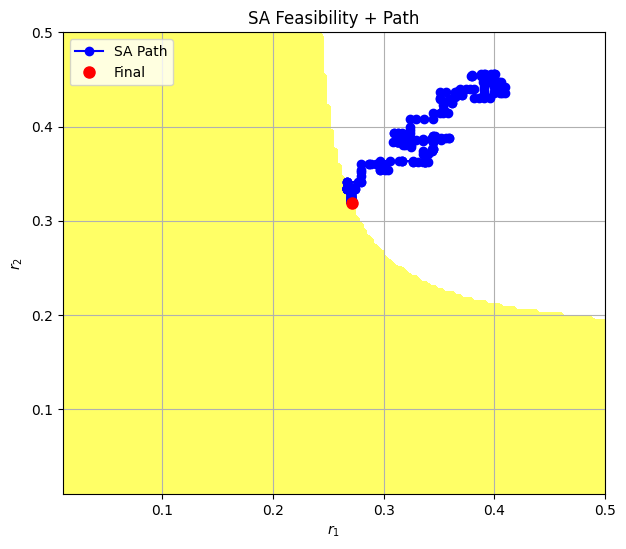

In [53]:
best_solution, best_val, history = simulated_annealing(
    r0=[0.4, 0.45],
    bounds=[(0.01, 0.5), (0.01, 0.5)]
)

# Check feasibility
print("Feasible?", is_feasible(best_solution))

# Print constraints
print("Constraints:", nonlincon(best_solution))

# Plot feasibility region and the path
plot_feasibility_and_path(history, bounds, N=150, title="SA Feasibility + Path")
